### File description


File name:  yale_face_apca_resconstruction.ipynb

Author:  Billy Carson

Date created:  07-26-2020

Last modified:  07-29-2020

> Description:  Uses aPCA formulations to reconstruct images from the Extended Yale Face Dataset B.


### Import modules

In [1]:
# Import modules
import os
import numpy as np
import time
import imageio
import PIL
from PIL import Image
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Import custom modules
from misc_utils import *
from adv_pca import *


### Function definitions

In [2]:
# Load cropped Yale face dataset B into matrix
def load_cropped_yaleb(dir_path, resize_factor=0.25):
    # Initialize feature and label lists
    X = []
    Y = []
    labels = []
    
    # Get list of sub-directories
    subdir_list = [x for x in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, x))]
    
    # Iterate over sub-directories
    for subdir in subdir_list:
        # Get list of files in sub-directory
        subdir_path = dir_path + subdir + '/PNG/'
        file_list = [x for x in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, x))]
        
        # Load images in subdirectory
        for file_name in file_list:
            # Load image
            if ('.png' in file_name) & ('bad' not in file_name) & ('Ambient' not in file_name):
                # Load image as numpy array
                # img = imageio.imread(subdir_path + file_name)
                img = Image.open(subdir_path + file_name)
                img_width, img_height = img.size
                img_resize = img.resize((int(resize_factor * img_width), int(resize_factor * img_height)), Image.ANTIALIAS)
                img_arr = np.array(img_resize)
                
                # Extract azimuth as concomitant variable
                azimuth = int(file_name[13:16])
                
                # Extract azimuth as concomitant variable
                elevation = int(file_name[17:20])
                
                # Extract label
                label = int(file_name[5:7])
                
                # Append to lists
                # X.append(np.reshape(img_arr, newshape=(1, -1)))
                X.append(img_arr.ravel())
                Y.append(np.array([azimuth, elevation]).ravel())
                labels.append(label)
                
    # Convert to arrays
    X = np.array(X)
    Y = np.array(Y)
    labels = np.array(labels)
    
    # Return arrays
    return X, Y, labels


### Load data

In [3]:
# Load data into arrays
dir_path = '/media/hdd_seagate_2tb/Files/Documents/Carlson_Lab/Data/Extended_Yale_Face_Database_B/Cropped_Yale_B/'
resize_factor = 0.25
X, Y, labels = load_cropped_yaleb(dir_path=dir_path, resize_factor=resize_factor)

# Image width and height
img_width = int(resize_factor * 168)
img_height = int(resize_factor * 192)

# Display data dimensions
print('\nData dimensions:\n')
print('  X shape:  (%d, %d)' % (X.shape))
print('  Y shape:  (%d, %d)' % (Y.shape))
print('  labels shape:  (%d,)\n' % (labels.shape))



Data dimensions:

  X shape:  (2414, 2016)
  Y shape:  (2414, 2)
  labels shape:  (2414,)



### Split data

In [4]:
# Create train and test indices
idx = np.arange(0, len(X), 1)
test_idx = np.array([186, 1674, 418, 151, 352, 722, 99, 501, 1607, 1806])
train_idx = np.arange(len(X))[list(set(np.arange(len(X))) - set(test_idx))]

# Divide data into train and test splits
X_train = X[train_idx, :]
X_test = X[test_idx, :]
Y_train = Y[train_idx]
Y_test = Y[test_idx]
labels_train = labels[train_idx]
labels_test = labels[test_idx]


### Scale data

In [5]:
# Initialize scaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Scale primary data
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Scale concomitant data
Y_train = scaler_Y.fit_transform(Y_train)
Y_test = scaler_Y.transform(Y_test)


### Define model parameters

In [6]:
# General model parameters
random_state = 0

# Number of components for PCA and aPCA models
n_components = 100

# aPCA adversarial strength
mu = 1e7


### Reconstruct image from PCA and aPCA components

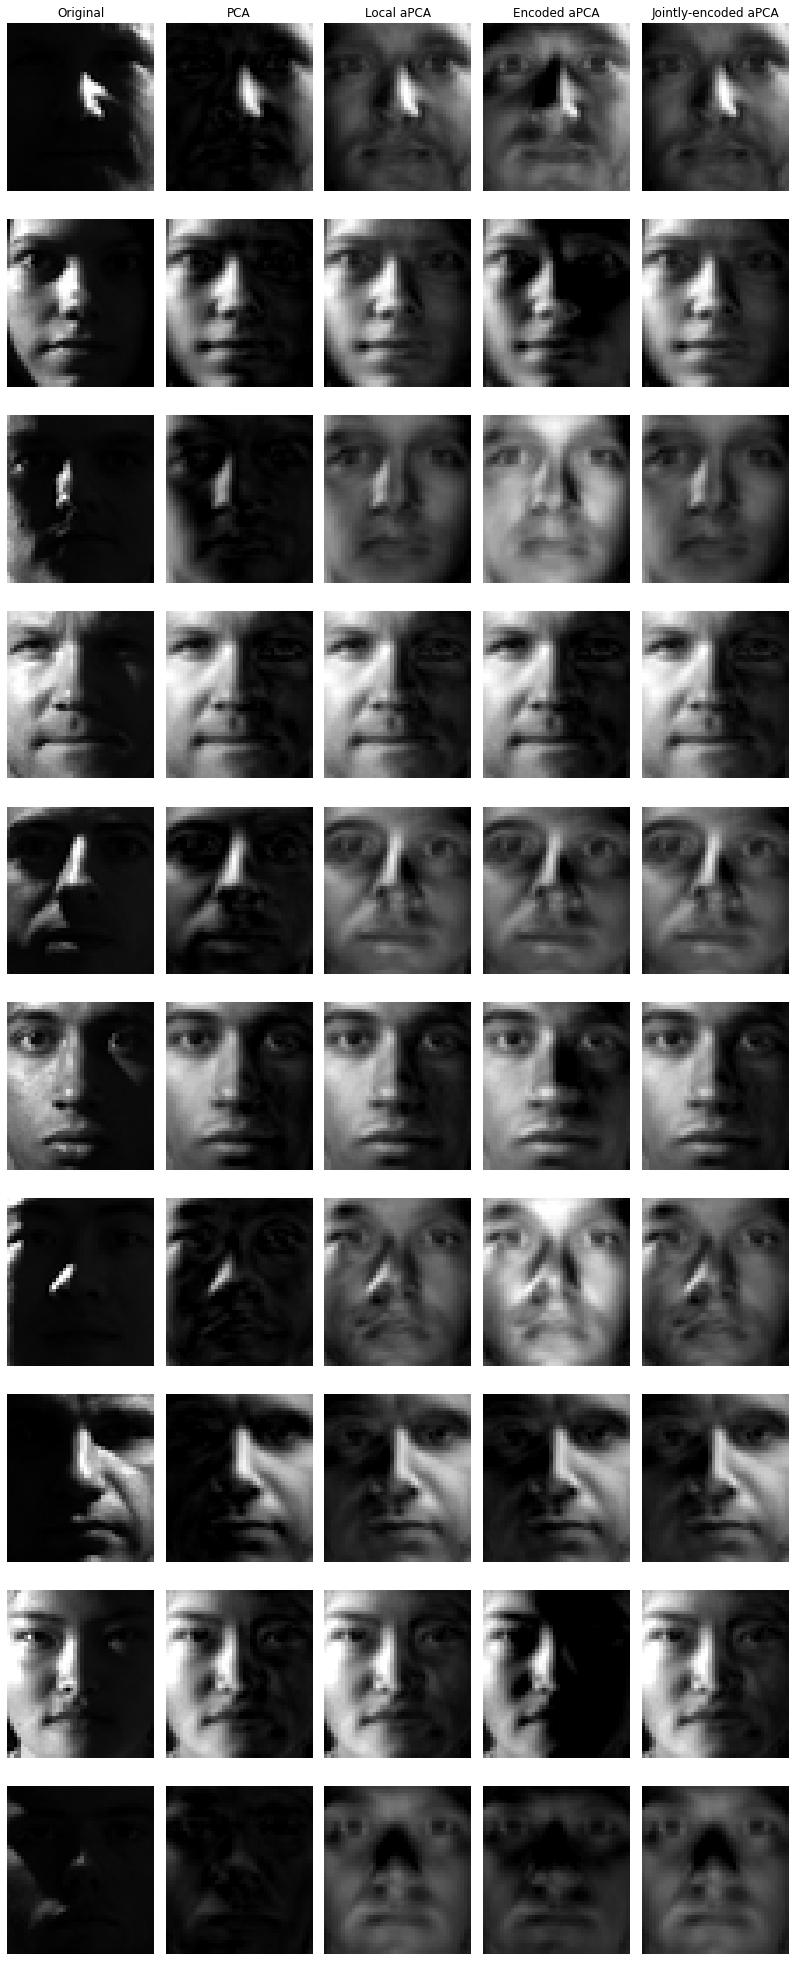

In [7]:
# Initialize PCA model
pca = PCA(n_components=n_components)

# Initialize aPCA models
lpca = LocalAdvPCA(n_components=n_components, mu=mu)
epca = EncodedAdvPCA(n_components=n_components, mu=mu)
jpca = JointAdvPCA(n_components=n_components, mu=mu)

# PCA decomposition
pca.fit(X_train)
S_pca = pca.transform(X_test)

# Local aPCA decomposition
lpca.fit(X=X_train, Y=Y_train)
S_lpca = lpca.transform(X=X_test, Y=Y_test)

# Encoded aPCA decomposition
epca.fit(X=X_train, Y=Y_train)
S_epca = epca.transform(X=X_test, Y=Y_test)

# Jointly-encoded aPCA decomposition
jpca.fit(X=X_train, Y=Y_train)
S_jpca = jpca.transform(X=X_test, Y=Y_test)
    
# Initialize figure
fig1, ax1 = plt.subplots(nrows=X_test.shape[0], ncols=5, figsize=(14, 36))

# Iterate over test instances
for i in range(X_test.shape[0]):
    # Original image
    img_orig = scaler_X.inverse_transform(X_test[[i], :])
    img_orig = np.reshape(img_orig, newshape=(img_height, img_width))
    img_orig = Image.fromarray(img_orig)

    # PCA image reconstruction
    img_recon_pca = S_pca[[i], :] @ pca.components_
    img_recon_pca = scaler_X.inverse_transform(img_recon_pca)
    img_recon_pca = np.reshape(img_recon_pca, newshape=(img_height, img_width))
    img_recon_pca = Image.fromarray(img_recon_pca)
    
    # Local aPCA image reconstruction
    img_recon_lpca = S_lpca[[i], :] @ lpca.W_.T
    img_recon_lpca = scaler_X.inverse_transform(img_recon_lpca)
    img_recon_lpca = np.reshape(img_recon_lpca, newshape=(img_height, img_width))
    img_recon_lpca = Image.fromarray(img_recon_lpca)

    # Encoded aPCA image reconstruction
    img_recon_epca = S_epca[[i], :] @ epca.W_.T
    img_recon_epca = scaler_X.inverse_transform(img_recon_epca)
    img_recon_epca = np.reshape(img_recon_epca, newshape=(img_height, img_width))
    img_recon_epca = Image.fromarray(img_recon_epca)

    # Jointly-encoded aPCA image reconstruction
    img_recon_jpca = S_jpca[[i], :] @ jpca.W_.T
    img_recon_jpca = scaler_X.inverse_transform(img_recon_jpca)
    img_recon_jpca = np.reshape(img_recon_jpca, newshape=(img_height, img_width))
    img_recon_jpca = Image.fromarray(img_recon_jpca)
    
    # Display image and reconstructions
    ax1[i, 0].imshow(img_orig)
    ax1[i, 1].imshow(img_recon_pca)
    ax1[i, 2].imshow(img_recon_lpca)
    ax1[i, 3].imshow(img_recon_epca)
    ax1[i, 4].imshow(img_recon_jpca)
    
    # No axis tickmarks
    ax1[i, 0].axis('off')
    ax1[i, 1].axis('off')
    ax1[i, 2].axis('off')
    ax1[i, 3].axis('off')
    ax1[i, 4].axis('off')
    ax1[i, 0].axis('off')
    ax1[i, 1].axis('off')
    ax1[i, 2].axis('off')
    ax1[i, 3].axis('off')
    ax1[i, 4].axis('off')

# Plot attributes
# fig1.suptitle('Image Reconstruction - Azimuth and Elevation Invariance')
ax1[0, 0].set_title('Original')
ax1[0, 1].set_title('PCA')
ax1[0, 2].set_title('Local aPCA')
ax1[0, 3].set_title('Encoded aPCA')
ax1[0, 4].set_title('Jointly-encoded aPCA')

# Show plot
plt.subplots_adjust(wspace=0.08, hspace=0.01)
plt.show()
